# GoDaddy - Microbusiness Density Forecasting

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np

from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
df=pd.read_csv("train.csv")#https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/

### EDA

In [3]:
df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100


In [4]:
df.isnull().sum() #We examine the empty lines.

row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
dtype: int64

In [5]:
df2=pd.read_csv("test.csv")

In [6]:
df2

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01
...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01
25076,56039_2023-06-01,56039,2023-06-01
25077,56041_2023-06-01,56041,2023-06-01
25078,56043_2023-06-01,56043,2023-06-01


In [7]:
df["county"].value_counts()

Washington County        1170
Jefferson County          975
Franklin County           936
Lincoln County            897
Jackson County            897
                         ... 
Androscoggin County        39
Winn Parish                39
West Feliciana Parish      39
West Carroll Parish        39
Weston County              39
Name: county, Length: 1871, dtype: int64

In [8]:
df["state"].value_counts()

Texas                   9906
Georgia                 6201
Virginia                5070
Kentucky                4680
Missouri                4485
Kansas                  4095
Illinois                3978
North Carolina          3900
Iowa                    3861
Tennessee               3705
Nebraska                3588
Indiana                 3588
Ohio                    3432
Minnesota               3393
Michigan                3237
Mississippi             3198
Oklahoma                3003
Arkansas                2925
Wisconsin               2808
Pennsylvania            2613
Alabama                 2613
Florida                 2613
South Dakota            2535
Colorado                2496
Louisiana               2496
New York                2418
California              2262
Montana                 2184
West Virginia           2145
North Dakota            2067
South Carolina          1794
Idaho                   1716
Washington              1521
Oregon                  1404
New Mexico    

In [9]:
df=df.drop(["county","state","active"],axis=1) #We delete some columns.

In [10]:
df

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2019-08-01,1001,2019-08-01,3.007682
1,1001_2019-09-01,1001,2019-09-01,2.884870
2,1001_2019-10-01,1001,2019-10-01,3.055843
3,1001_2019-11-01,1001,2019-11-01,2.993233
4,1001_2019-12-01,1001,2019-12-01,2.993233
...,...,...,...,...
122260,56045_2022-06-01,56045,2022-06-01,1.803249
122261,56045_2022-07-01,56045,2022-07-01,1.803249
122262,56045_2022-08-01,56045,2022-08-01,1.785395
122263,56045_2022-09-01,56045,2022-09-01,1.785395


In [11]:
df["first_day_of_month"]=pd.to_datetime(df["first_day_of_month"])
df["day"]=(df["first_day_of_month"]).dt.day
df["month"]=(df["first_day_of_month"]).dt.month
df["year"]=(df["first_day_of_month"]).dt.year
#We divide date into 4 as day, month and year.

In [12]:
df

,row_id,cfips,first_day_of_month,microbusiness_density,day,month,year
0,1001_2019-08-01,1001,2019-08-01,3.007682,1,8,2019
1,1001_2019-09-01,1001,2019-09-01,2.884870,1,9,2019
2,1001_2019-10-01,1001,2019-10-01,3.055843,1,10,2019
3,1001_2019-11-01,1001,2019-11-01,2.993233,1,11,2019
4,1001_2019-12-01,1001,2019-12-01,2.993233,1,12,2019
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,2022-06-01,1.803249,1,6,2022
122261,56045_2022-07-01,56045,2022-07-01,1.803249,1,7,2022
122262,56045_2022-08-01,56045,2022-08-01,1.785395,1,8,2022
122263,56045_2022-09-01,56045,2022-09-01,1.785395,1,9,2022


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   first_day_of_month     122265 non-null  datetime64[ns]
 3   microbusiness_density  122265 non-null  float64       
 4   day                    122265 non-null  int64         
 5   month                  122265 non-null  int64         
 6   year                   122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 6.5+ MB


In [14]:
del df["first_day_of_month"]

In [15]:
df

,row_id,cfips,microbusiness_density,day,month,year
0,1001_2019-08-01,1001,3.007682,1,8,2019
1,1001_2019-09-01,1001,2.884870,1,9,2019
2,1001_2019-10-01,1001,3.055843,1,10,2019
3,1001_2019-11-01,1001,2.993233,1,11,2019
4,1001_2019-12-01,1001,2.993233,1,12,2019
...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,1.803249,1,6,2022
122261,56045_2022-07-01,56045,1.803249,1,7,2022
122262,56045_2022-08-01,56045,1.785395,1,8,2022
122263,56045_2022-09-01,56045,1.785395,1,9,2022


In [16]:
df["day"].value_counts()

1    122265
Name: day, dtype: int64

In [17]:
df2["first_day_of_month"]=pd.to_datetime(df2["first_day_of_month"])
df2["day"]=(df2["first_day_of_month"]).dt.day
df2["month"]=(df2["first_day_of_month"]).dt.month
df2["year"]=(df2["first_day_of_month"]).dt.year

In [18]:
df2

,row_id,cfips,first_day_of_month,day,month,year
0,1001_2022-11-01,1001,2022-11-01,1,11,2022
1,1003_2022-11-01,1003,2022-11-01,1,11,2022
2,1005_2022-11-01,1005,2022-11-01,1,11,2022
3,1007_2022-11-01,1007,2022-11-01,1,11,2022
4,1009_2022-11-01,1009,2022-11-01,1,11,2022
...,...,...,...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01,1,6,2023
25076,56039_2023-06-01,56039,2023-06-01,1,6,2023
25077,56041_2023-06-01,56041,2023-06-01,1,6,2023
25078,56043_2023-06-01,56043,2023-06-01,1,6,2023


In [19]:
del df2["first_day_of_month"]

In [20]:
df2["day"].value_counts()

1    25080
Name: day, dtype: int64

In [21]:
del df2["day"]
del df["day"]

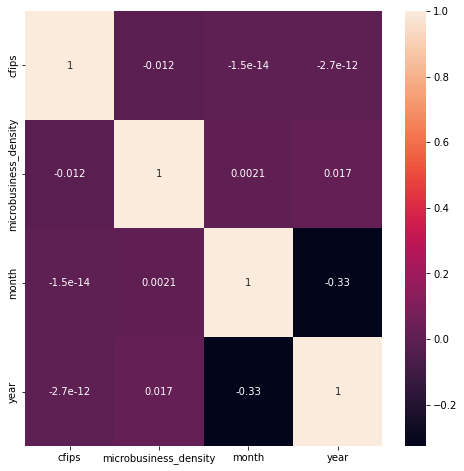

In [22]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),annot=True);

In [23]:
abs(df.corr()["microbusiness_density"].sort_values(ascending=False)) #We look at their correlations.

microbusiness_density    1.000000
year                     0.017025
month                    0.002121
cfips                    0.011767
Name: microbusiness_density, dtype: float64

### Data Visualization

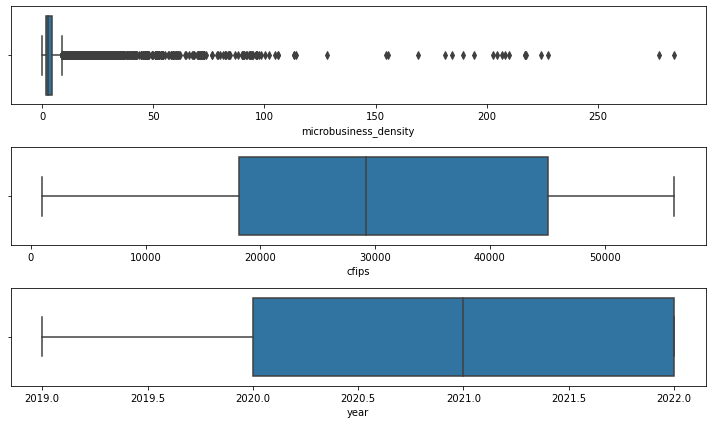

In [24]:
fig = plt.figure(figsize=(10,6))
fig.add_subplot(3,1,1)
sns.boxplot(df['microbusiness_density'])
fig.add_subplot(3,1,2)
sns.boxplot(df['cfips'])
fig.add_subplot(3,1,3)
sns.boxplot(df['year'])
plt.tight_layout();

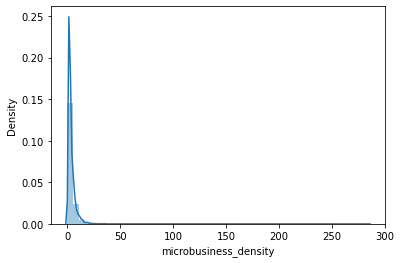

In [25]:
sns.distplot(df['microbusiness_density']);

In [26]:
df=df[df['microbusiness_density']<25]

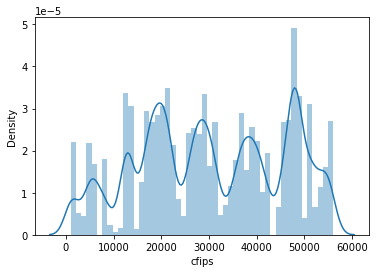

In [27]:
sns.distplot(df['cfips']);

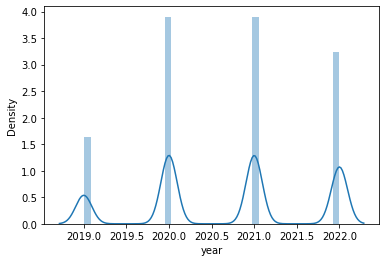

In [28]:
sns.distplot(df['year']);

In [29]:
df

,row_id,cfips,microbusiness_density,month,year
0,1001_2019-08-01,1001,3.007682,8,2019
1,1001_2019-09-01,1001,2.884870,9,2019
2,1001_2019-10-01,1001,3.055843,10,2019
3,1001_2019-11-01,1001,2.993233,11,2019
4,1001_2019-12-01,1001,2.993233,12,2019
...,...,...,...,...,...
122260,56045_2022-06-01,56045,1.803249,6,2022
122261,56045_2022-07-01,56045,1.803249,7,2022
122262,56045_2022-08-01,56045,1.785395,8,2022
122263,56045_2022-09-01,56045,1.785395,9,2022


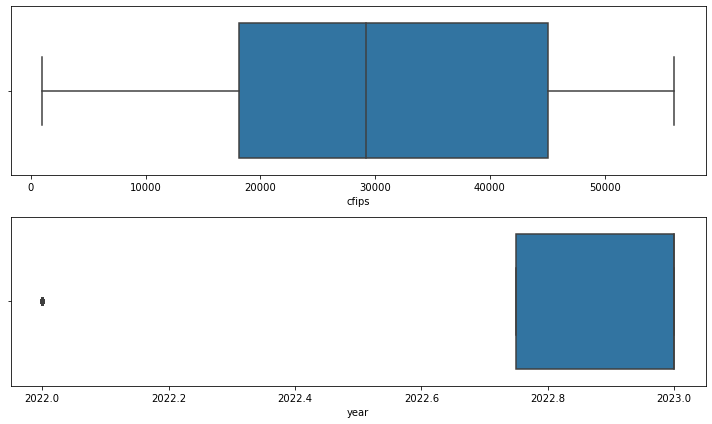

In [30]:
fig = plt.figure(figsize=(10,6))
fig.add_subplot(2,1,1)
sns.boxplot(df2['cfips'])
fig.add_subplot(2,1,2)
sns.boxplot(df2['year'])
plt.tight_layout();

In [31]:
abs(df.corr()["microbusiness_density"].sort_values(ascending=False))

microbusiness_density    1.000000
month                    0.006473
year                     0.003661
cfips                    0.029891
Name: microbusiness_density, dtype: float64

In [32]:
df

,row_id,cfips,microbusiness_density,month,year
0,1001_2019-08-01,1001,3.007682,8,2019
1,1001_2019-09-01,1001,2.884870,9,2019
2,1001_2019-10-01,1001,3.055843,10,2019
3,1001_2019-11-01,1001,2.993233,11,2019
4,1001_2019-12-01,1001,2.993233,12,2019
...,...,...,...,...,...
122260,56045_2022-06-01,56045,1.803249,6,2022
122261,56045_2022-07-01,56045,1.803249,7,2022
122262,56045_2022-08-01,56045,1.785395,8,2022
122263,56045_2022-09-01,56045,1.785395,9,2022


### Regression

In [33]:
x=df[["cfips"]]
y=df[["microbusiness_density"]]

In [34]:
x.shape

(121667, 1)

In [35]:
def algo_test(x,y):
    L = LinearRegression()
    E = ElasticNet()
    R = Ridge()
    Lass = Lasso()
    ETR=ExtraTreeRegressor()
    GBR=GradientBoostingRegressor()
    XGBC= XGBRegressor()
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=13)
    algos = [L,E,R,Lass,ETR,GBR,XGBC]
    algo_names = ['Linear','ElasticNet','Ridge','Lasso','Extra Tree','Gradient Boosting','XGradientBooting']
    r_squared = []
    rmse = []
    mae = []
    result = pd.DataFrame(columns = ['R_Squared','RMSE','MAE'],index = algo_names)
    for algo in algos:
        algo.fit(x_train,y_train)    
        r_squared.append(r2_score(y_test,algo.predict(x_test)))
        rmse.append(mean_squared_error(y_test, algo.predict(x_test))**.5)
        mae.append(mean_absolute_error(y_test, algo.predict(x_test)))
    result.R_Squared = r_squared
    result.RMSE = rmse
    result.MAE= mae
    return result.sort_values('R_Squared', ascending=False)

In [36]:
algo_test(x,y)

,R_Squared,RMSE,MAE
Extra Tree,0.971054,0.531887,0.213632
XGradientBooting,0.771251,1.495214,1.080331
Gradient Boosting,0.321794,2.574567,1.783341
Linear,0.001148,3.124453,2.192245
Ridge,0.001148,3.124453,2.192245
ElasticNet,0.001148,3.124453,2.192244
Lasso,0.001148,3.124453,2.192243


In [118]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42)

In [119]:
model=Sequential()
model.add(Dense(12,activation="relu"))
model.add(Dense(12,activation="relu"))
model.add(Dense(12,activation="relu"))
model.add(Dense(12,activation="relu"))
model.add(Dense(12,activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

In [120]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=128,epochs=150)
model.summary()

Epoch 1/150
761/761 [==============================] - 2s 1ms/step - loss: 517767.7500 - val_loss: 12.6940
Epoch 2/150
761/761 [==============================] - 1s 1ms/step - loss: 12.5929 - val_loss: 12.6985
Epoch 3/150
761/761 [==============================] - 1s 1ms/step - loss: 12.5876 - val_loss: 12.6891
Epoch 4/150
761/761 [==============================] - 1s 1ms/step - loss: 12.5796 - val_loss: 12.7982
Epoch 5/150
761/761 [==============================] - 1s 1ms/step - loss: 12.5688 - val_loss: 12.6560
Epoch 6/150
761/761 [==============================] - 1s 1ms/step - loss: 12.5625 - val_loss: 12.6279
Epoch 7/150
761/761 [==============================] - 1s 1ms/step - loss: 12.5388 - val_loss: 12.7091
Epoch 8/150
761/761 [==============================] - 1s 1ms/step - loss: 12.4941 - val_loss: 12.5320
Epoch 9/150
761/761 [==============================] - 1s 1ms/step - loss: 12.4542 - val_loss: 12.7245
Epoch 10/150
761/761 [==============================] - 1s 1ms/step -

                                                                 
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________


In [121]:
tahmin=model.predict(x_test)

761/761 [==============================] - 1s 596us/step


In [122]:
r2_score(tahmin,y_test)

-2789621290624676.5

In [123]:
(mean_squared_error(tahmin,y_test))**0.5

3.1492946414696448

In [85]:
df.to_csv("train1.csv")

In [98]:
x_test=df2[["cfips"]]

In [99]:
ETR=ExtraTreeRegressor()
ETR.fit(x,y)
tahmin=ETR.predict(x_test)

In [101]:
sonuc=df2[["row_id"]]

In [102]:
sonuc["microbusiness_density"]=tahmin

In [103]:
sonuc

,row_id,microbusiness_density
0,1001_2022-11-01,3.164535
1,1003_2022-11-01,7.889811
2,1005_2022-11-01,1.102521
3,1007_2022-11-01,1.270834
4,1009_2022-11-01,1.676951
...,...,...
25075,56037_2023-06-01,3.119993
25076,56039_2023-06-01,3.119993
25077,56041_2023-06-01,3.946930
25078,56043_2023-06-01,2.904894


In [109]:
sonuc.to_csv("ExtraTreeRegressor_tahmini.csv",index=False)

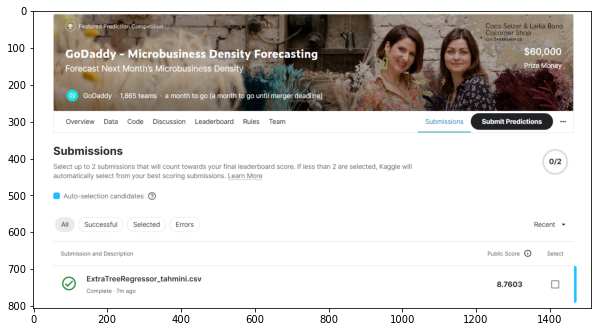

In [114]:
from PIL import Image
a=np.array(Image.open("sonuc.png"))
plt.figure(figsize=(10,6))
plt.imshow(a);